In [1]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd

Load system model and generation/demand profiles from Excel, adapted from the network in Example 11_9 in PowerWorld Simulator 18 (Glover, Sarma & Overbye Edition) [Fourth Edition Sample Cases](https://www.powerworld.com/simulator-18-glover-sarma-overbye-edition-download)

In [2]:
model = pd.read_excel('Example11_9_Network_Model_24hour.xlsx', sheet_name=None)
gen = pd.read_excel('Normalized generation profiles.xlsx', sheet_name='Normalized', index_col=0)

Here, we'll define as variables some important problem parameters.

In [3]:
# Read Ybus matrix
Y = model['YBus']
Y = Y.drop(columns=['Number', 'Name'])
Y = Y.apply(lambda row: row.str.replace('j', ''))
Y = Y.apply(lambda row: row.str.replace(' ', ''))
Y = Y + 'j'
Y = Y.fillna(0)
Y = Y.applymap(complex)
Y = np.array(Y)

# Number of buses
N = Y.shape[0]

# Susceptance matrix. Recall in DC power flow, G = 0 and shunt admittances are zero.
B = np.array(np.imag(Y))
B = B - np.diag(np.diag(B))
B = B - np.diag(np.sum(B, axis=0))

# System base, in MVA
base = 100

# Line constraints. The i, j element is the MVA limit of the line from bus i to bus j
P_line = np.zeros((N,N))
limits = model['Line']
P_line[limits['From Number']-1, limits['To Number']-1] = limits['Lim A MVA']
P_line = (P_line+P_line.T)/base

# The buses with generators and loads
L = np.array(model['Load']['Number of Bus']-1)
G = np.array(model['Gen']['Number of Bus']-1)

# Transformation matrices. These define the change-of-variables from the generator/load spaces to the bus space.
AG = np.zeros((N,len(G)))
AG[G,:] = np.eye(len(G))
AL = np.zeros((N,len(L)))
AL[L,:] = np.eye(len(L))

# Elasticity
e = -0.5

We solve a **demand-side** problem with zero marginal cost, fixed supply, and elastic demand. For this minimal example, we make the follwing assumptions:
- Each load submits a demand curve. The system operator dispatches to maximize total utlity $U(P)$.
- For each load, elasticity is constant. That is, the marginal utility for load $i$ is given by $\frac{dU_i}{dP_i}=K_iP_i^{\frac{1}{e_i}}$, where $e_i<0$ is the elasticity. Note that this formulation insures that marginal benefit is always positive.
- There is no upper limit on consumption.

First, we'll generate the input dataframe for our problem    

In [4]:
gen.index+=pd.TimedeltaIndex(gen.HE-1, unit='h')
gen = gen.drop(columns='HE')
gen = gen[model['Gen']['Type']].apply(np.array, axis='columns')
gen = gen.apply(lambda x: x*np.array(model['Gen']['Installed MW']))
gen.name = 'Maximum Generation'
demand = model['LoadProfiles'].set_index('Date')
demand.index+=pd.TimedeltaIndex(demand.HE-1, unit='h')
demand = demand.drop(columns='HE')
load = demand.loc[:,demand.columns.str.contains('Load')].apply(np.array, axis='columns')
load.name = 'Fixed Load'
price = demand.loc[:,demand.columns.str.contains('Price')].apply(np.array, axis='columns')
price.name = 'Fixed Price'
results = pd.DataFrame(gen).join([load, price], how='inner')
results

,Maximum Generation,Fixed Load,Fixed Price
2040-08-31 00:00:00,"[0.0, 129.602418314071, 33.962214470203996]","[171.51092219999998, 179.4569554, 35.19853168,...","[116.93256, 118.97675, 121.02094, 115.79821]"
2040-08-31 01:00:00,"[0.0, 113.828847090441, 24.247041220939]","[166.6615603, 173.60906169999998, 35.0303564, ...","[105.56723, 106.82196, 108.67215, 104.05731]"
2040-08-31 02:00:00,"[0.0, 109.38907539808099, 17.8813384488017]","[166.86314320000002, 168.85196159999998, 33.77...","[105.77841, 106.44, 108.14506, 103.17422]"
2040-08-31 03:00:00,"[0.0, 98.40019833973001, 18.295139644261997]","[167.5274569, 168.29895919999998, 32.14408192,...","[101.5313, 101.85271, 103.343, 99.13791]"
2040-08-31 04:00:00,"[0.0, 87.86679584247301, 18.339083137483996]","[168.2726596, 172.9792929, 33.28974936, 0.8731...","[102.00335, 102.06857, 103.61817, 99.306]"
2040-08-31 05:00:00,"[0.0, 81.269047515498, 18.530725585040997]","[177.27835340000001, 181.36929179999998, 35.45...","[110.00505, 110.74835, 112.22265, 107.88901]"
2040-08-31 06:00:00,"[0.0, 73.03070624219299, 20.847524020022]","[184.2996358, 192.0457921, 37.4122472, 0.97535...","[144.82762, 147.66208, 150.07741, 144.15445]"
2040-08-31 07:00:00,"[15.7233600004613, 68.11334957110401, 31.33903...","[188.3138078, 214.1110143, 41.9272488, 1.05894...","[109.68961, 108.52131, 110.33382, 104.39403]"
2040-08-31 08:00:00,"[242.056031652222, 62.099316269693006, 24.0041...","[183.5652373, 226.433301, 42.610611920000004, ...","[90.36649, 89.96, 92.12793, 85.31702]"
2040-08-31 09:00:00,"[532.305799601396, 57.168693348023005, 17.8557...","[175.68758300000002, 241.71976579999998, 41.81...","[89.83286, 90.24425, 92.61545, 84.75606]"


This function accepts an input dataframe as generated above and runs the full simulation. It modifies the input dataframe in-place to include the results.

In [5]:
def sim(input):

    T = len(input)

    p_g_max = np.stack(input['Maximum Generation']/base).T
    
    K = np.stack(input['Fixed Price'])/np.stack(input['Fixed Load']/base)**(1/e)
    K = K.T

    p_d = cp.Variable((len(L), T))
    p_g = cp.Variable((len(G), T))
    delta = cp.Variable((N, T))
    constraints = [
        AG@p_g-AL@p_d == -B@delta,
        p_g <= p_g_max,
        p_g >= 0
    ] + [
        cp.multiply(B, delta_t[:,np.newaxis]-delta_t[np.newaxis,:]) <= P_line 
        for delta_t in delta.T
    ]
    cp.Problem(
        cp.Maximize(e/(1+e)*cp.sum(cp.multiply(K,(p_d)**(1/e+1)))),
        constraints
    ).solve()

    to_column = lambda x: pd.Series(x, index=input.index)

    input['Dispatched Generation'] = to_column(list(p_g.value.T))*base
    input['Dispatched Load'] = to_column(list(p_d.value.T))*base
    input['LMP'] = -to_column(list(constraints[0].dual_value.T))
    input['Congestion'] = to_column([constraint.dual_value for constraint in constraints[3:]])

Run the simulation

In [6]:
sim(results)

Plot the results

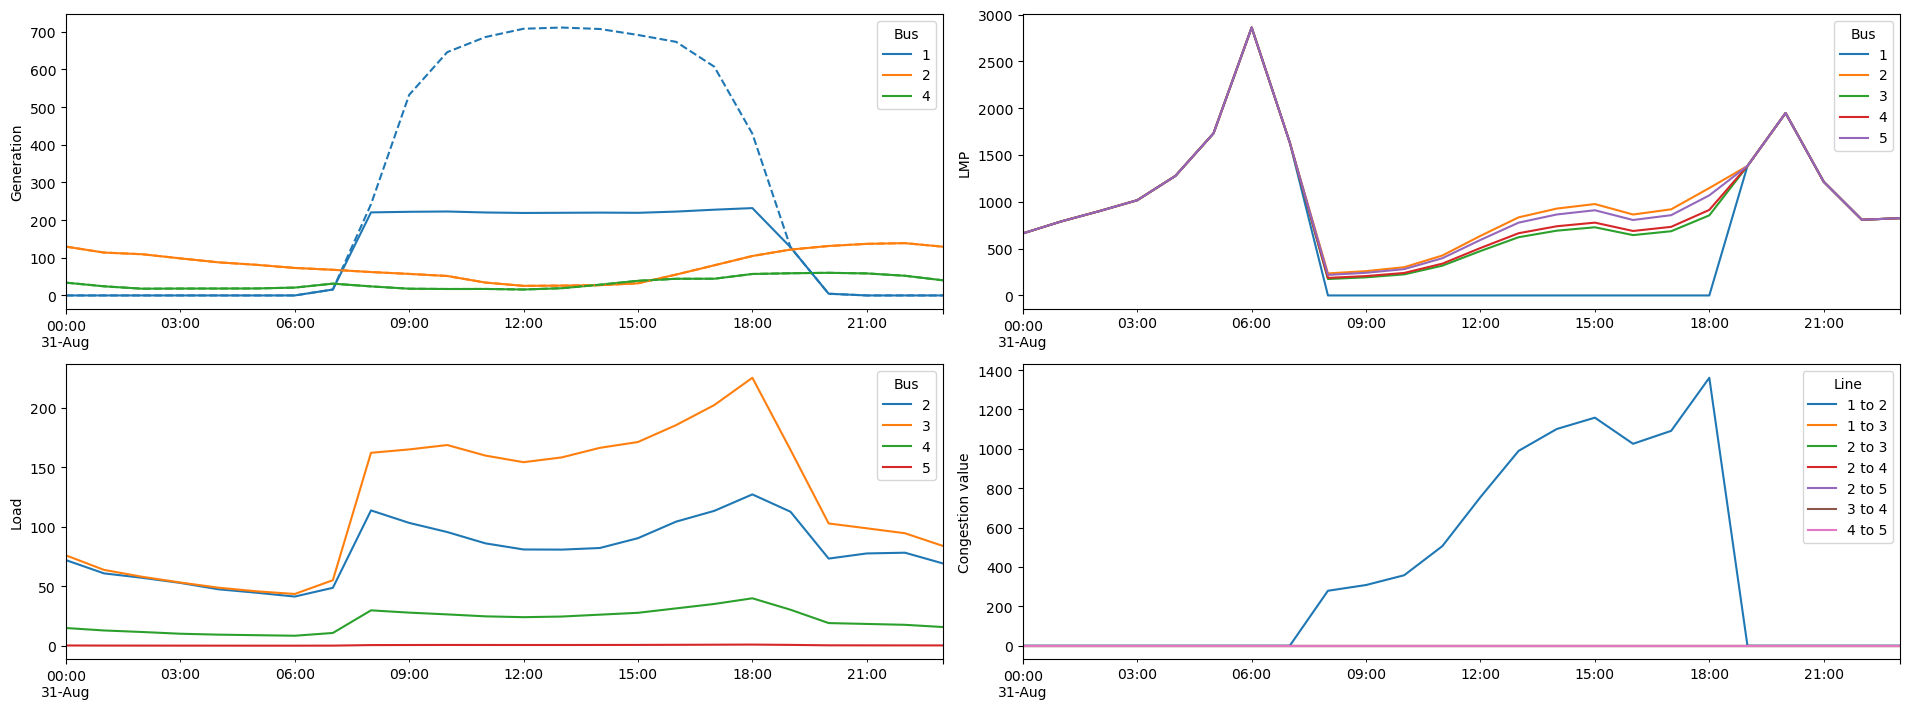

In [7]:
fig, ax = plt.subplots(2,2)

results['Dispatched Generation'].apply(pd.Series).plot(ax=ax[0,0])
colors = [line.get_color() for line in ax[0,0].lines]
results['Maximum Generation'].apply(pd.Series).plot(ax=ax[0,0], linestyle='dashed', color=colors)
ax[0,0].set_ylabel('Generation')
ax[0,0].legend(G+1, title='Bus')

results['LMP'].apply(pd.Series).plot(ax=ax[0,1])
ax[0,1].set_ylabel('LMP')
ax[0,1].legend(range(1,N+1), title='Bus')

results['Dispatched Load'].apply(pd.Series).plot(ax=ax[1,0])
ax[1,0].set_ylabel('Load')
ax[1,0].legend(L+1, title='Bus')

idx = np.array(np.where(P_line != 0))
results['Congestion'].apply(
    lambda M: pd.Series(
        {
            f'{i+1} to {j+1}': M[i,j]-M[j,i]
            for i, j in idx[:,idx[0] < idx[1]].T
        }
    )
).plot(ax=ax[1,1])
ax[1,1].set_ylabel('Congestion value')
ax[1,1].legend(title='Line')

fig.set_size_inches(fig.get_size_inches()*[3,1.5])
fig.tight_layout()
fig.show()